In [8]:
pip install pyvi

In [9]:
import numpy as py
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, GRU, Input, GlobalMaxPooling1D, LayerNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras. preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from pyvi import ViUtils

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
data = pd. read_csv("/content/drive/My Drive/CD/_Viettel_ Data_ sentiment - Trang tính1 (1).csv", encoding="UTF-8")
data.head(10)

,Comment,Label,Unnamed: 2
0,Camera Viettel này rất tệ mua máy của eviz về ...,Neg,NaN
1,"Đừng nên tải mn ơi. em mất 400k rồi, gửi tiền ...",Neg,NaN
2,Ứng dụng ViettelHome giúp tôi tiết kiệm thời g...,Pos,NaN
3,Đang cần chuyển tiền mà vào app thì kêu là bị ...,Neg,NaN
4,Rất ấn tượng với giao diện thân thiện và dễ sử...,Pos,NaN
5,Ứng dụng này thật sự hữu ích! Tôi không phải l...,Pos,NaN
6,rất thuận tiện cho cuộc sống hàng ngày!,Pos,NaN
7,Tôi cảm thấy an tâm hơn khi đang ở một nơi khá...,Pos,NaN
8,"Giao dịch liên tục lỗi,hiện thông báo trừ tiền...",Neg,NaN
9,Cảm ơn ViettelHome vì đã mang đến cho tôi một ...,Pos,NaN


In [12]:
sentiment_data = pd.DataFrame({'input':data['Comment'], 'label':data['Label']})
sentiment_data = sentiment_data.dropna()
sentiment_data = sentiment_data.reset_index(drop=True)
sentiment_data.head()

,input,label
0,Camera Viettel này rất tệ mua máy của eviz về ...,Neg
1,"Đừng nên tải mn ơi. em mất 400k rồi, gửi tiền ...",Neg
2,Ứng dụng ViettelHome giúp tôi tiết kiệm thời g...,Pos
3,Đang cần chuyển tiền mà vào app thì kêu là bị ...,Neg
4,Rất ấn tượng với giao diện thân thiện và dễ sử...,Pos


PREPROCESSING DATA & PREPARE DATA FOR TRANING

In [13]:
input_data = sentiment_data['input'].values
input_label = sentiment_data['label'].values

label_dict = {'Neg':0,'Pos':1}

input_pre = []
label_with_accent = []
for idx, dt in enumerate(input_data):
  #input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
  input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(str(dt)))
  input_text_pre = " ".join(input_text_pre)
  input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))
  input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
  input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)
  input_pre.append(input_text_pre_accent)
  input_pre.append(input_text_pre_no_accent)
  label_with_accent.append(input_label[idx])
  label_with_accent.append(input_label[idx])


In [14]:
negative_count = len(data[data['Label'] == 'Neg'])
print("Số lượng nhãn Negative là:", negative_count)

positive_count = len(data[data['Label'] == 'Pos'])
print("Số lượng nhãn Positive là:", positive_count)

Số lượng nhãn Negative là: 646
Số lượng nhãn Positive là: 457


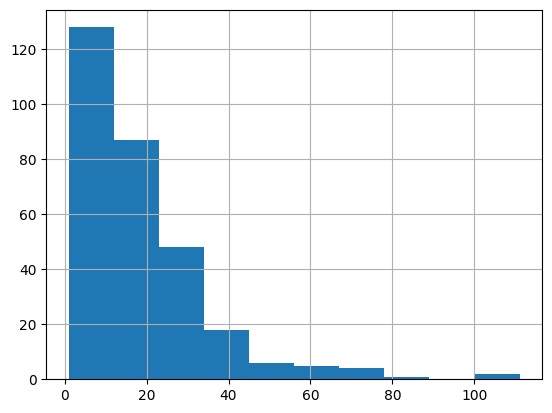

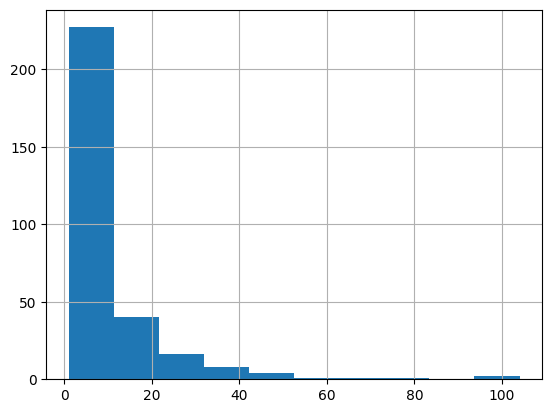

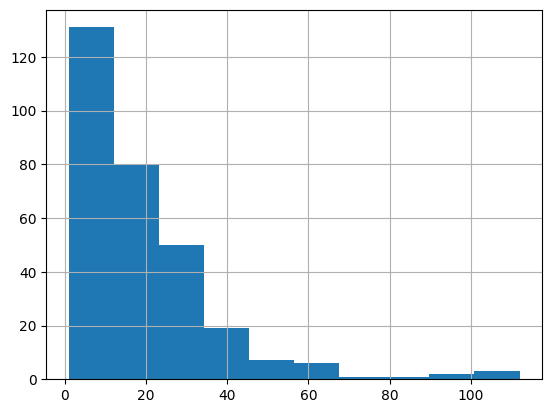

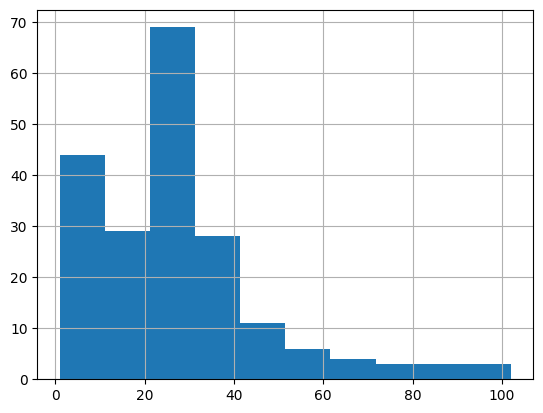

In [15]:
seq_len = [len(i.split()) for i in input_pre[1:300]]
pd.Series(seq_len).hist(bins=10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[300:600]]
pd.Series(seq_len).hist(bins=10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[600:900]]
pd.Series(seq_len).hist(bins=10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[900:1100]]
pd.Series(seq_len).hist(bins=10)
plt.show()


In [16]:
label_idx = [label_dict[i] for i in label_with_accent]
label_tf = tf.keras.utils.to_categorical(label_idx, num_classes=3, dtype='float32')

tokenizer_data = Tokenizer(oov_token='<OOV>', filters = '', split = ' ')
tokenizer_data.fit_on_texts(input_pre)

tokenizer_data_text = tokenizer_data.texts_to_sequences(input_pre)
vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen = 120)

pickle.dump(tokenizer_data, open("tokenizer_data.pkl", "wb"))

print("input data.shape", vec_data.shape)
data_vocab_size = len(tokenizer_data.word_index)+1
print("data_vocab_size: ", data_vocab_size)

X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(vec_data, label_tf, test_size=0.1, random_state=42)
print("Training sample: ", len(X_train))
print("Validation sample: ", len(X_val))
print("Test sample: ", len(X_test))

input data.shape (2206, 120)
data_vocab_size:  2878
Training sample:  1985
Validation sample:  442
Test sample:  221


In [17]:
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Bidirectional, LSTM
from keras.models import Model
from keras.optimizers import Adam

CREATE MODEL FROM SCRATCH

In [18]:
def generate_model():
  dropout_threshold = 0.4
  input_dim = data_vocab_size
  output_dim = 32
  input_length = 120
  initializer = tf.keras.initializers.GlorotNormal()

  input_layer = Input(shape=input_length)
  feature = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, embeddings_initializer="GlorotNormal")(input_layer)

  cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(feature)
  cnn_feature = MaxPooling1D()(cnn_feature)
  cnn_feature = Dropout(dropout_threshold)(cnn_feature)
  cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(cnn_feature)
  cnn_feature = MaxPooling1D()(cnn_feature)
  cnn_feature = LayerNormalization()(cnn_feature)
  cnn_feature = Dropout(dropout_threshold)(cnn_feature)

  bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode = 'concat')(feature)
  bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)

  bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode = 'concat')(bi_lstm_feature)
  bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
  bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

  combine_feature = tf.keras.layers.Concatenate()([cnn_feature, bi_lstm_feature])
  combine_feature = GlobalMaxPooling1D()(combine_feature)
  combine_feature = LayerNormalization()(combine_feature)

  classifier = Dense(90, activation = 'relu')(combine_feature)
  classifier = Dropout(0.2)(classifier)
  classifier = Dense(70, activation = 'relu')(classifier)
  classifier = Dropout(0.2)(classifier)
  classifier = Dense(50, activation = 'relu')(classifier)
  classifier = Dropout(0.2)(classifier)
  classifier = Dense(30, activation = 'relu')(classifier)
  classifier = Dropout(0.2)(classifier)
  classifier = Dense(3, activation = 'softmax')(classifier)

  model = tf.keras.Model(inputs = input_layer, outputs= classifier)

  return model

model = generate_model()
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 120)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 120, 32)              92096     ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 120, 32)              3104      ['embedding[0][0]']           
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 60, 32)               0         ['conv1d[0][0]']              
 D)                                                                                           

In [19]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.h5', monitor='val_loss')
history = model.fit(x = X_train, y = y_train, validation_data = (X_val, y_val), epochs = 10, batch_size = 128, callbacks=[callback_model])

Epoch 1/10
16/16 [==============================] - 38s 407ms/step - loss: 0.8231 - accuracy: 0.5597 - val_loss: 0.5998 - val_accuracy: 0.7760
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 3s 176ms/step - loss: 0.6083 - accuracy: 0.6902 - val_loss: 0.4145 - val_accuracy: 0.8258
Epoch 3/10
16/16 [==============================] - 3s 167ms/step - loss: 0.4813 - accuracy: 0.7960 - val_loss: 0.3447 - val_accuracy: 0.8597
Epoch 4/10
16/16 [==============================] - 2s 128ms/step - loss: 0.3622 - accuracy: 0.8655 - val_loss: 0.1778 - val_accuracy: 0.9367
Epoch 5/10
16/16 [==============================] - 2s 105ms/step - loss: 0.2145 - accuracy: 0.9335 - val_loss: 0.1613 - val_accuracy: 0.9502
Epoch 6/10
16/16 [==============================] - 2s 120ms/step - loss: 0.1337 - accuracy: 0.9627 - val_loss: 0.1134 - val_accuracy: 0.9683
Epoch 7/10
16/16 [==============================] - 3s 196ms/step - loss: 0.1048 - accuracy: 0.9683 - val_loss: 0.0910 - val_accuracy: 0.9683
Epoch 8/10
16/16 [==============================] - 2s 107ms/step - loss: 0.0869 - accuracy: 0.9804 - val_loss: 0.0837 - val_accuracy: 0.9683
Epoch 9/10
16/16 

In [20]:
model.load_weights("model_cnn_bilstm.h5")
model.evaluate(X_test,y_test)

7/7 [==============================] - 0s 23ms/step - loss: 0.2485 - accuracy: 0.9502


[0.24854278564453125, 0.9502262473106384]

In [21]:
labels = ["Neg","Pos"]

y_pred = model.predict(X_val)  # Dự đoán trên tập validation
# y_pred = model.predict(X_test)  # Dự đoán trên tập test

14/14 [==============================] - 2s 13ms/step


In [22]:
import numpy as np

y_pred = [labels[np.argmax(pred)] for pred in y_pred]
y_true = [labels[np.argmax(true)] for true in y_val]  # Nhãn thực tế trên tập validation
# y_true = [labels[np.argmax(true)] for true in y_test]  # Nhãn thực tế trên tập test

In [23]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, zero_division=1)
print(report)

              precision    recall  f1-score   support

         Neg       0.96      0.99      0.98       246
         Pos       0.99      0.95      0.97       196

    accuracy                           0.98       442
   macro avg       0.98      0.97      0.97       442
weighted avg       0.98      0.98      0.98       442



INFERENCE MODEL WITH INPUT TEST

In [24]:
def preprocess_raw_input(raw_input, tokenizer):
  input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
  input_text_pre = " ".join(input_text_pre)
  input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
  print("Text preprocessed: ", input_text_pre_accent)
  tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
  vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=120)
  return vec_data

def inference_model(input_feature, model):
  output = model(input_feature).numpy()[0]
  result = output.argmax()
  conf = float(output.max())
  label_dict = {'Tiêu cực':0, 'Tích cực':1}
  label = list(label_dict.keys())
  return label[int(result)], conf

def prediction(raw_input, tokenizer, model):
  input_model = preprocess_raw_input(raw_input, tokenizer_data)
  result, conf = inference_model(input_model, model)

  return result, conf

my_model = generate_model()
my_model = load_model('model_cnn_bilstm.h5')

with open(r"tokenizer_data.pkl", "rb") as input_file:
  my_tokenizer = pickle.load(input_file)

print(prediction("Ứng dụng tệ không thể tả nổi! Một tập đoàn lớn như thế mà làm ăn chán", my_tokenizer, my_model))

Text preprocessed:  ứng_dụng tệ không_thể tả nổi một tập_đoàn lớn như thế_mà làm_ăn chán
('Tiêu cực', 0.9999929666519165)


In [25]:
while(True):
  text = input()
  if text == "end":
    break
  else:
    print(prediction(text, my_tokenizer, my_model)[0] + "\n")

KeyboardInterrupt: Interrupted by user